In [9]:
import pandas as pd
import sqlite3

In [10]:
con = sqlite3.connect('../data/checking-logs.sqlite')

In [11]:
pd.read_sql('SELECT name FROM  sqlite_master WHERE type="table"', con)

,name
0,pageviews
1,checker
2,deadlines


---
### Weekends average number of commits per hour

In [12]:
query = """
SELECT
    holy.hour,
    (SUM(holy.dates_count) * 1.0 / COUNT(holy.hour)) weekends_average
FROM
    (SELECT
        hour,
        COUNT(date) dates_count
    FROM
        (SELECT
            strftime('%Y-%m-%d', timestamp) date,
            strftime('%H', timestamp) hour,
            CASE
                WHEN strftime("%w", timestamp) IN ('0', '6')
                    THEN 1
                ELSE 0
            END weekday
        FROM
            checker
        WHERE
            uid LIKE 'user%'
            AND
            weekday=1)
    GROUP BY
        hour,
        date) holy
GROUP BY
    holy.hour
"""
weekends_avg_commits_per_hour = pd.read_sql(query, con, index_col='hour')
# weekends_avg_commits_per_hour['hour'] = pd.to_numeric(weekends_avg_commits_per_hour['hour'],
#                                                       downcast='unsigned')
# weekends_avg_commits_per_hour.set_index('hour', inplace=True)
weekends_avg_commits_per_hour['weekends_average'] = pd.to_numeric(weekends_avg_commits_per_hour['weekends_average'],
                                                                 downcast='float')
weekends_avg_commits_per_hour.head()

,weekends_average
hour,
00,2.0
01,6.0
03,1.0
05,2.0
07,4.0


---
### Wordays average number of commits per hour

In [13]:
query = """
SELECT
    workdays.hour,
    (SUM(workdays.dates_count) * 1.0 / COUNT(workdays.hour)) workdays_average
FROM
    (SELECT
        hour,
        COUNT(date) dates_count
    FROM
        (SELECT
            strftime('%Y-%m-%d', timestamp) date,
            strftime('%H', timestamp) hour,
            CASE
                WHEN strftime("%w", timestamp) IN ('0', '6')
                    THEN 1
                ELSE 0
            END weekday
        FROM
            checker
        WHERE
            uid LIKE 'user%'
            AND
            weekday=0)
    GROUP BY
        hour,
        date) workdays
GROUP BY
    workdays.hour
"""
workdays_avg_commits_per_hour = pd.read_sql(query, con, index_col='hour')
# workdays_avg_commits_per_hour['hour'] = pd.to_numeric(workdays_avg_commits_per_hour['hour'],
#                                                       downcast='unsigned')
# workdays_avg_commits_per_hour.set_index('hour', inplace=True)
workdays_avg_commits_per_hour['workdays_average'] = pd.to_numeric(workdays_avg_commits_per_hour['workdays_average'],
                                                                 downcast='float')
workdays_avg_commits_per_hour.head()

,workdays_average
hour,
00,3.000000
03,2.000000
05,7.500000
06,1.500000
07,5.166667


---
## Concatenating two dataframes, adding missing rows, filling NaN values

In [14]:
avg_commits_per_hour = weekends_avg_commits_per_hour.join(workdays_avg_commits_per_hour, how='outer')
avg_commits_per_hour.index = avg_commits_per_hour.index.astype("int")

for hour in range(24):
    if hour not in avg_commits_per_hour.index:
        avg_commits_per_hour.loc[hour] = [0, 0]
avg_commits_per_hour = avg_commits_per_hour.sort_index().fillna(0)
avg_commits_per_hour

,weekends_average,workdays_average
hour,,
0,2.000000,3.000000
1,6.000000,0.000000
2,0.000000,0.000000
3,1.000000,2.000000
4,0.000000,0.000000
5,2.000000,7.500000
6,0.000000,1.500000
7,4.000000,5.166667
8,7.000000,3.700000


---
## Drawing a plot

array([<AxesSubplot:title={'center':'weekends'}, xlabel='hour'>,
       <AxesSubplot:title={'center':'workdays'}, xlabel='hour'>],
      dtype=object)

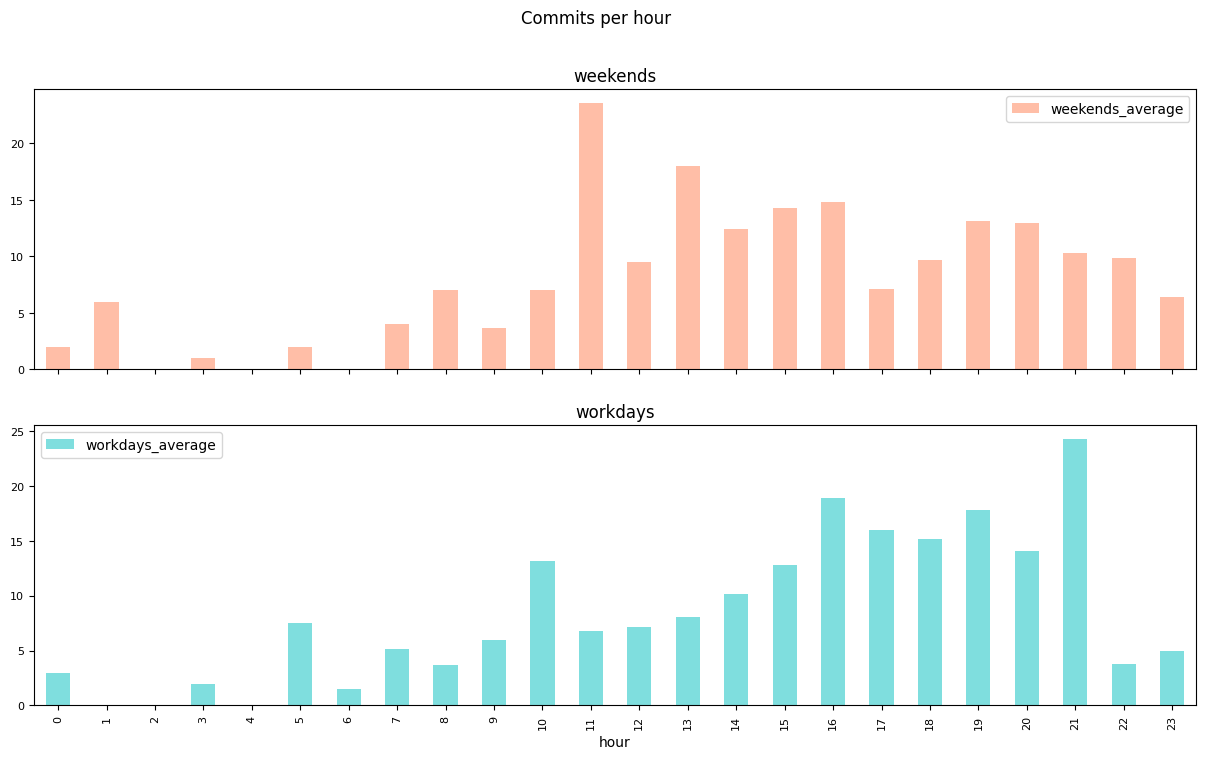

In [15]:
plt = avg_commits_per_hour.plot(title='Commits per hour',
                                kind='bar', subplots=True,
                                figsize=(15, 8), fontsize=8, color=['coral', 'c'], alpha=0.5)
plt[0].set_title('weekends')
plt[1].set_title('workdays')
plt

---
## Closing the connection

In [16]:
con.close()

---
## Question

#### Is the dynamic different on working days and weekends?
> For the answer include the hour when the number of commits is the largest during working days and the hour when it is the largest during the weekend

---
## Answer

`weekends` moda is ***11***, meanwhile `workdays` - ***21***\
Moreover, plots show us that during the ***weekends*** commits are primerily made in the ***afternoon***, ***workdays***, on the contrary, have commits mostly in the ***evening***.